In [1]:
from skimage import io, color
import numpy as np

In [2]:
img = io.imread('test.jpg')

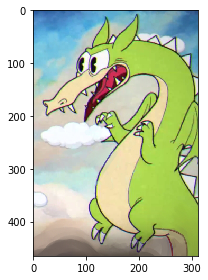

In [3]:
io.imshow(img)

In [4]:
grayscale_img = color.rgb2gray(img)

In [86]:
def translation_matrix(*args):
    dim = len(args)
    translation = np.array(args)
    m = np.eye(dim + 1, dim + 1)
    m[:dim, -1] = translation
    return m

def scaling_matrix(*args):
    dim = len(args)
    scaling = np.array(args)
    m = np.diag(np.append(scaling, 1))
    return m

In [87]:
translation_matrix(1, 2, 3)

array([[1., 0., 0., 1.],
       [0., 1., 0., 2.],
       [0., 0., 1., 3.],
       [0., 0., 0., 1.]])

In [88]:
scaling_matrix(0.5, 1)

array([[0.5, 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ]])

In [138]:
def apply_transform(image, inverse_transform):
    if inverse_transform.shape != (3, 3):
        raise "This is 2D world, leave your 3D stuff at home"
    coords_tensor = np.mgrid[:image.shape[1], :image.shape[0]]
    coords_tensor = np.vstack((coords_tensor, np.ones(image.shape[::-1])[np.newaxis, ...]))
    transformed_coords = np.transpose(np.transpose(coords_tensor, (1, 2, 0)).dot(inverse_transform.T), (2, 0, 1))
    transformed_coords /= transformed_coords[-1]
    result = np.zeros_like(image)
    def check_bounds(y, x, y_max, x_max):
        return y in np.arange(y_max) and x in np.arange(x_max)
    result = np.apply_along_axis(lambda coords: image[coords[1], coords[0]]
                                 if check_bounds(coords[0], coords[1], image.shape[1], image.shape[0]) else 0.0,
                                 2, transformed_coords[:-1].T.astype(int))
    return result

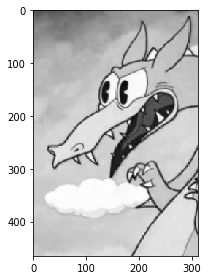

In [139]:
io.imshow(apply_transform(grayscale_img, np.linalg.inv(scaling_matrix(1.5, 1.5))))

In [140]:
from skimage.transform import ProjectiveTransform, warp

In [141]:
transform = ProjectiveTransform(scaling_matrix(1.5, 1.5))

In [142]:
warped_img = warp(grayscale_img, transform.inverse, preserve_range=True)

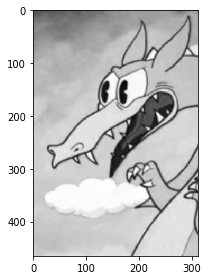

In [143]:
io.imshow(warped_img)

In [115]:
from time import time

skimage_time_history = []

for i in range(100):
    start = time()
    warp(grayscale_img, transform.inverse, preserve_range=True)
    skimage_time_history.append(time() - start)
    
print("average skimage time:", np.mean(skimage_time_history))

average skimage time: 0.006219265460968018


In [116]:
my_time_history = []

for i in range(5):
    start = time()
    apply_transform(grayscale_img, scaling_matrix(1.5, 1.5))
    my_time_history.append(time() - start)
    
print("my average time:", np.mean(my_time_history))

(3, 312, 465)
(3, 312, 465)
(3, 312, 465)
(3, 312, 465)
(3, 312, 465)
my average time: 3.686241292953491


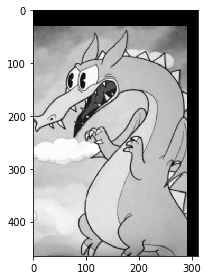

In [144]:
io.imshow(apply_transform(grayscale_img, np.linalg.inv(translation_matrix(-20, 30))))

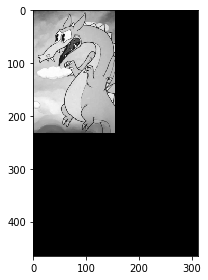

In [145]:
io.imshow(apply_transform(grayscale_img, np.linalg.inv(scaling_matrix(0.5, 0.5))))

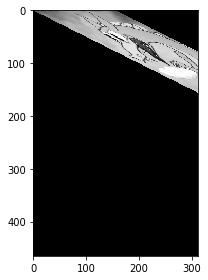

In [151]:
io.imshow(apply_transform(grayscale_img, np.linalg.inv(np.array([
    [0.5, 1, 0],
    [0, 0.5, 0],
    [0, 0, 1]
]))))

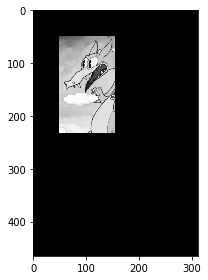

In [152]:
io.imshow(apply_transform(
    apply_transform(grayscale_img, np.linalg.inv(translation_matrix(100, 100))),
    np.linalg.inv(scaling_matrix(0.5, 0.5))))

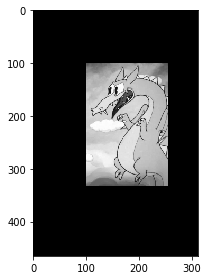

In [153]:
io.imshow(apply_transform(grayscale_img, np.linalg.inv(translation_matrix(100, 100) @ scaling_matrix(0.5, 0.5))))

Здесь одновременно применяется сдвиг на (100, 100) и сжатие в два раза, поэтому никакие части изображения не обрезаются в отличие от первого случая, когда сначала был обрезан нижний правый угол, а уже потом изображение было сжато с центром в (0, 0). Получается, как бы, что центр сжатия смещается.

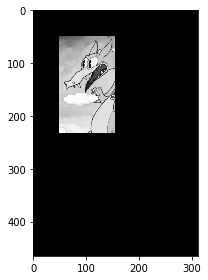

In [156]:
io.imshow(warp(warp(grayscale_img, ProjectiveTransform(translation_matrix(100, 100)).inverse),
               ProjectiveTransform(scaling_matrix(0.5, 0.5)).inverse))

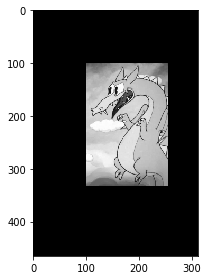

In [157]:
io.imshow(warp(grayscale_img, ProjectiveTransform(translation_matrix(100, 100) @ scaling_matrix(0.5, 0.5)).inverse))

Операция, конечно, ассоциативна, да вот не совсем. И во всём виноваты границы изображения.